In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
from collections import Counter, namedtuple
import re
import markov_clustering as mc
import networkx as nx
import numpy as np

In [6]:
data = []

clusters = {}
with open('../data/unknown_nterm_clustered_70.fa.clstr') as infile:
    for line in infile:
        hits = re.search(f'>(.+?)(($)|(\.\.\.))', line)
        if not hits:
            continue
        if hits.group(1).startswith('Cluster'):
            cluster = hits.group(1)
        else:
            clusters[hits.group(1)] = cluster


for record in SeqIO.parse('../data/seqs/unknown_nterm.fa', 'fasta'):
    species = re.search('\[(.+)?\]', record.description).group(1)
    seqlen = len(record.seq)
    data.append([species, seqlen, f'{record.name}', clusters.get(record.id, np.nan)])
df = pd.DataFrame(data, columns=['species', 'seqlen', 'name', 'cluster']).dropna().sort_values('cluster')
print(df.head())
print(df.size)

                      species  seqlen                  name    cluster
93048      Oxyura jamaicensis     277  XP_035192477.1_nterm  Cluster 0
36570    Dasypus novemcinctus     266  XP_004459738.1_nterm  Cluster 0
29060           Columba livia     284  XP_005512673.1_nterm  Cluster 0
99214     Peromyscus leucopus     266  XP_028710217.1_nterm  Cluster 0
114574  Rousettus aegyptiacus     271  XP_016019269.1_nterm  Cluster 0
517372


In [7]:
def species_diversity(df):
    nseqs = len(df)
    nspecies = len(set(df.species))
    return nspecies/nseqs

cluster_df = df.groupby('cluster').apply(species_diversity).sort_values().reset_index()
print(cluster_df)

             cluster         0
0         Cluster 78  0.008850
1          Cluster 8  0.009009
2        Cluster 197  0.016949
3        Cluster 200  0.016949
4        Cluster 228  0.019231
...              ...       ...
45720  Cluster 25145  1.000000
45721  Cluster 25146  1.000000
45722  Cluster 25147  1.000000
45723  Cluster 25149  1.000000
45724   Cluster 9999  1.000000

[45725 rows x 2 columns]


In [24]:
for row in cluster_df.head(100).iterrows():
    print(row[1].cluster, f'{row[1][0]:.3f}')
    print(Counter(df.loc[df.cluster == row[1].cluster, 'species']))
    print(df.loc[df.cluster == row[1].cluster, 'seqlen'].describe())
    print()

Cluster 78 0.009
Counter({'Danio rerio': 113})
count    113.000000
mean      73.920354
std       12.212509
min       31.000000
25%       73.000000
50%       77.000000
75%       82.000000
max      105.000000
Name: seqlen, dtype: float64

Cluster 8 0.009
Counter({'Astyanax mexicanus': 221, 'Stegodyphus dumicola': 1})
count    222.000000
mean      14.936937
std        6.933791
min       12.000000
25%       14.000000
50%       14.000000
75%       14.000000
max      105.000000
Name: seqlen, dtype: float64

Cluster 197 0.017
Counter({'Acanthochromis polyacanthus': 59})
count    59.000000
mean     36.847458
std       4.381834
min      36.000000
25%      36.000000
50%      36.000000
75%      36.000000
max      60.000000
Name: seqlen, dtype: float64

Cluster 200 0.017
Counter({'Rana temporaria': 59})
count     59.000000
mean      95.966102
std       43.647872
min       54.000000
25%       70.000000
50%       70.000000
75%      112.000000
max      268.000000
Name: seqlen, dtype: float64

Cluster

In [9]:
clust_df = df.groupby('cluster')[['name']].count().sort_values('name').reset_index()
for c in clust_df.tail(100)['cluster']:
    print(f'CLUSTER {c}')
    print(df.loc[df.cluster == c].groupby('species')['name'].count().sort_values())
    print()
# print(df.loc[df.species.str.contains('Cypr')].groupby('cluster')['species'].count().sort_values())

CLUSTER Cluster 97
species
Acanthochromis polyacanthus         1
Pungitius pungitius                 1
Pundamilia nyererei                 1
Pseudochaenichthys georgianus       1
Poecilia reticulata                 1
                                   ..
Girardinichthys multiradiatus       1
Gasterosteus aculeatus aculeatus    1
Kryptolebias marmoratus             1
Xiphophorus maculatus               1
Archocentrus centrarchus            2
Name: name, Length: 96, dtype: int64

CLUSTER Cluster 98
species
Acanthisitta chloris       1
Nestor notabilis           1
Neopelma chrysocephalum    1
Myiozetetes cayanensis     1
Motacilla alba alba        1
                          ..
Corvus brachyrhynchos      1
Corapipo altera            1
Columba livia              1
Gallus gallus              1
Zonotrichia albicollis     1
Name: name, Length: 97, dtype: int64

CLUSTER Cluster 99
species
Acinonyx jubatus                1
Pan troglodytes                 1
Pan paniscus                    1
Ovis

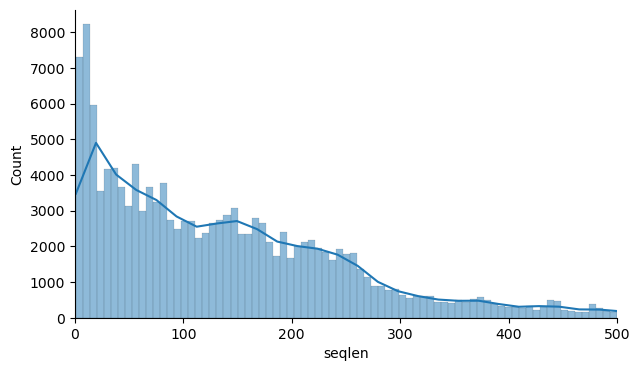

In [122]:
fig, ax = plt.subplots(figsize=(7, 4))
# sns.histplot(df.loc[df.species == 'Octopus bimaculoides', 'seqlen'], ax=ax, kde=True, log_scale=False, binwidth=10)
sns.histplot(df.seqlen, ax=ax, kde=True, log_scale=False)
ax.set_xlim(0, 500)
sns.despine()
plt.show()

In [95]:
# for i in range(20, 40):
    # print(i)
print(df.loc[(df.seqlen >= 25) & (df.seqlen <= 35)].groupby('species')['name'].count().sort_values().tail(5))
    # print()

species
Branchiostoma floridae     84
Eriocheir sinensis        109
Astyanax mexicanus        146
Octopus sinensis          273
Octopus bimaculoides      285
Name: name, dtype: int64


In [ ]:
print(species)

In [297]:
def extract_kmers(seqfile, k=5):
    kmers = Counter()
    for record in SeqIO.parse(seqfile, 'fasta'):
        seq = list(str(record.seq))
        # for i in range(len(seq)-k):
        for i in range(40):
            kmer = ''.join(seq[i:i+k])
            if len(kmer) != k:
                continue
            kmers[kmer] += 1
    return kmers

nterm_kmers = extract_kmers('../data/seqs/unknown_nterm.fa')
cterm_kmers = extract_kmers('../data/seqs/unknown_cterm.fa')
sprot_kmers = extract_kmers('/Users/jonwells/Genomes/Uniprot/uniprot_sprot.fasta')

data = []
for key in set(nterm_kmers.keys()).intersection(cterm_kmers.keys(), sprot_kmers.keys()):
    data.append([key, nterm_kmers.get(key, 0), cterm_kmers.get(key, 0), sprot_kmers.get(key, 0)])
df = pd.DataFrame(data, columns=['kmer', 'nterm', 'cterm', 'sprot'] ) \
       .sort_values('nterm') \
       .reset_index(drop=True)


In [302]:
df['nege'] = df['kmer'].apply(lambda x: 'EE' in x)
df['negd'] = df['kmer'].apply(lambda x: 'WW' in x)
df = df.loc[~df.kmer.str.contains('X')]
print(df.tail(20))

         kmer  nterm  cterm  sprot   nege   negd
443070  EESED   1414      5     28   True  False
443071  ERLTA   1555      5     36  False  False
443072  IKEES   1592      6      6   True  False
443073  TAAAE   1619      9     44  False  False
443074  FLVKK   1678      1     35  False  False
443075  AEEIF   1710      1     31   True  False
443076  QQQQQ   1791   5001   1701  False  False
443077  AAAEE   1890     40    142   True  False
443078  TGEKP   1921    206     61  False  False
443079  HTGEK   1997    173     67  False  False
443080  FIKEE   2035      4     12   True  False
443081  KEESE   2044      8      8   True  False
443082  AAEEI   2058      2     39   True  False
443083  LTAAA   2229     33    256  False  False
443084  RLTAA   2263      4    131  False  False
443085  SFLVK   2856      2     30  False  False
443086  MPRSF   2985      1     27  False  False
443087  EEEEE   3220   2355    926   True  False
443088  SRRKQ   4122      1     39  False  False
443089  MSRRK   4182

/Users/jonwells/miniconda3/envs/python3_env/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/jonwells/miniconda3/envs/python3_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


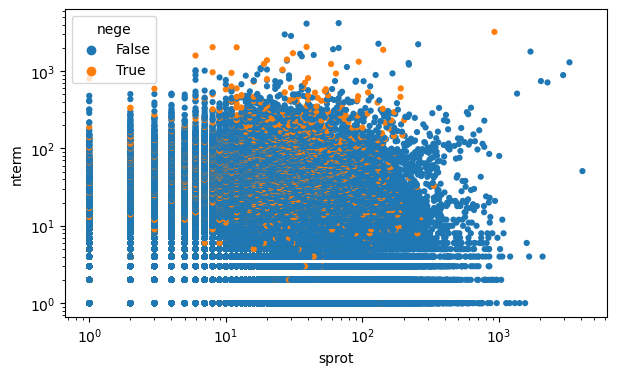

In [303]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(data=df, x='sprot', y='nterm', hue='nege', linewidth=0, s=20)
ax.set_xscale('log')
ax.set_yscale('log')

KeyError: 'n'

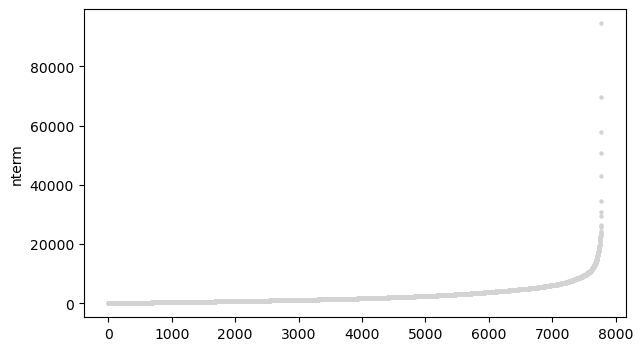

In [257]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(data=df, 
                y='nterm', 
                x=df.index, 
                ax=ax, 
                linewidth=0, 
                s=10,
                color='lightgrey')
markerline, stemlines, baseline = plt.stem(list(df.loc[df.nege == True].index), 
                                           df.loc[df.nege == True, 'n'], 
                                           linefmt='red',
                                           bottom=1)
baseline.remove()
markerline.set_markerfacecolor('red')
markerline.set_markeredgecolor('k')

markerline, stemlines, baseline = plt.stem(list(df.loc[df.negd == True].index), 
                                           df.loc[df.negd == True, 'n'], 
                                           linefmt='gold',
                                           bottom=1)

baseline.remove()
markerline.set_markerfacecolor('gold')
markerline.set_markeredgecolor('k')


ax.set_yscale('log')
sns.despine()
plt.show()